This notebook is dedicated to training a NN to perform sentiment analysis on tweets. It uses a large training set of 1.5M labeled tweets from http://thinknook.com/twitter-sentiment-analysis-training-corpus-dataset-2012-09-22/ and a module I wrote to judge how often words show up in pos vs neg tweets (Sentiment_LUT)

In [2]:
import re
import pandas as pd
import pickle
import numpy as np
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import Sentiment_LUT

In [3]:
#a simple way to process the training data to make it look like the data collected from Twitter in another notebook.
def clean_tweet(tweet):
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())

#The GloVe table uses information from https://nlp.stanford.edu/projects/glove/ to convert words to numberic 1d vectors.
#This def just creates a look up table for taking a word and quickly finding its vector representation.
#dimension: can be 25, 50, 200, etc. sets size of word vector representation
def GloVe_table(dimension):
    file=open('NLP_files/glove.twitter.27B.%sd.txt'%(dimension), 'r',encoding="utf8")
    contents=file.read()
    contents_lines=contents.split('\n')
    GloVe=pd.DataFrame([line.split(' ') for line in contents_lines[0:]])
    GloVe.set_index(0,inplace=True) #set the word as the index for faster look-up table function
    return GloVe.iloc[:,:].astype(float).copy()

#This uses the Sentiment_LUT module I made previously to judge how often a word shows up in pos tweets vs neg tweets.
#If the word shows up more often in one or the other, it will be useful to include in the analysis.
#the sentiment_strength variable sets how extreme the imbalance in appearance between pos and neg tweets the word must have
#to be used in the analysis.
def sent_words(tweet,LUT,sentiment_strength):
    tweet_words=pd.Series(tweet.split(' '));
    #adding exception in the case there are no sentiment words in tweet.
    #In that case, return original tweet.
    try:
        #a=' '.join(tweet_words[list(np.abs(LUT.loc[tweet_words.split(' '),'Score'])>sentiment_strength)])
        a=' '.join(tweet_words[(np.abs(LUT.loc[tweet_words,'Score'])>sentiment_strength).values])
    except:
        #a=tweet
        a=''
    return a

#using the GloVe table and sentiment look up table to create vectorized representations of tweets.
#names of IMDB and LUT25 are left over from previous work with different training data and GloVe tables.
def vectorize(IMDB,dimension,LUT25):
    def vector(word):
        try:
            return LUT25.loc[word,:]
        except:
            return np.zeros(len(LUT25.iloc[0,:]))
    def vector2(word_list):
        words=pd.Series(word_list)
        a=words.apply(vector).values.mean(axis=0)
        return list(a)
    for x in range(0,dimension):
        IMDB.loc[:,'vector_%s'%(x)]=0
    IMDB.loc[:,IMDB.columns[IMDB.columns.str.contains('vector')]]=IMDB.loc[:,'sentiment words'].str.split(' ').apply(vector2).apply(pd.Series).values
    return IMDB

Creating the sentiment look up table (if not already made)

In [90]:
n=200000
try:
    LUT_sentiment_words=pd.read_csv('LUT_sentiment_words_%s.csv'%(n))
    LUT_sentiment_words.set_index('words',inplace=True)
except:
    %time LUT_sentiment_words=Sentiment_LUT.LUT(n)
    LUT_sentiment_words.to_csv('LUT_sentiment_words_%s.csv'%(n),index=False)
    LUT_sentiment_words.set_index('words',inplace=True)

Wall time: 36.9 s


Set the parameters for the neural network.

In [94]:
training_tweets_per_label=100000 #1/2 of total training data Can go up to 1.5M/2, but slows training.
sentiment=0.25; #the threshold to limit words in tweets used to make vector representation to only words found more often in pos or neg tweets.
dimension=50; #dimension of word vectors. Needs to be a dimension downloaded from Stanford's GloVe data.
nodes=200 #number of nodes in the single layer neural network

And prepare the word vectors

In [6]:
%time GloVe=GloVe_table(dimension)

Wall time: 1min 2s


First, need to prepare the training set. I save a csv file of training set with these parameters so I don't have to remake it each time I open this notebook.

In [ ]:
#using just a subset of the available data to keep run times managable
#training_tweets_per_label=10000 #uncomment all if not set above
#sentiment=0.2;
#dimension=50;
try:
    Training_set=pd.read_csv('Training_set_sentiment_%s_vector_%s_size_%s.csv'%(sentiment, dimension,training_tweets_per_label));
    print('training set already made')
except:
    #print('GloVe time')
    #%time GloVe=GloVe_table(dimension)
    #only taking a sample of the full 1.5M tweets in the training set
    Training_set=pd.read_csv('NLP_files/SentimentAnalysisDataset.csv',usecols=['Sentiment','SentimentText'])
    Training_set_neg_sample=Training_set.loc[Training_set.loc[:,'Sentiment']==0,:].sample(training_tweets_per_label);
    Training_set_pos_sample=Training_set.loc[Training_set.loc[:,'Sentiment']==1,:].sample(training_tweets_per_label);
    Training_set_sample=pd.concat([Training_set_neg_sample,Training_set_pos_sample])
    Training_set_sample.reset_index(inplace=True)
    del Training_set_sample['index']
    Training_set=Training_set_sample.copy()
    Training_set.rename(columns={"SentimentText": "tweets"},inplace=True)
    #cleaning the set:
    Training_set['tweets']=Training_set['tweets'].str.lower()
    punctuation=['.','?','!','/',';',':','(',')'];
    for elm in punctuation:
        Training_set.loc[:,'tweets']=Training_set.loc[:,'tweets'].str.replace('%s'%elm,' %s '%elm)
    Training_set.loc[:,'tweets']=Training_set.loc[:,'tweets'].apply(clean_tweet)
    #finding the words that pass the sentiment threshold test for being more often in one type of tweet or the other
    print('sentiment word time')
    %time Training_set['sentiment words']=Training_set.loc[:,'tweets'].apply(lambda tweet: sent_words(tweet,LUT_sentiment_words,sentiment))
    #converting tweets into vectores by averaging the word vectors of all the words in the tweet that passed the sentiment threshold
    print('vectorizing time')
    %time Training_set=vectorize(Training_set.loc[:,:],dimension,GloVe)
    Training_set.fillna(0,inplace=True)
    #and save the sentiment and vectorized tweets so this doesn't have to be redone with same parameters later
    Training_set.to_csv('Training_set_sentiment_%s_vector_%s_size_%s.csv'%(sentiment, dimension,training_tweets_per_label),index=False)

sentiment word time


# Training a Neural Network

At this point, I can start to train the neural network. There are several parameters I might want to change, from sentiment threshold values to neurons in the neural network. I'll do some EDA to find the best mix of parameters for the final system.

## First, looking at dependence on sentiment threshold

In [18]:
thresholds=[.1,.15,0.2,0.25,0.35]
nodes=200
#dimension=50; #uncomment if not set above
training_tweets_per_label=10000
df_results=pd.DataFrame(columns=['Threshold','trainAcc','testAcc'])
x=0;
runs=3
for y in range(0,runs):
    print('start round %s'%(y))
    for val in thresholds:
        sentiment=val;
        try:
            Training_set=pd.read_csv('Training_set_sentiment_%s_vector_%s_size_%s.csv'%(sentiment, dimension,training_tweets_per_label));
            #print('start run %s'%(y))
            train=Training_set.sample(int(.9*len(Training_set)));
            test=Training_set.loc[[index for index in Training_set.index if index not in train.index],:]
            vecIndex=train.columns[train.columns.str.contains('vector')]
            labelIndex='Sentiment'
            #nodes=150#uncomment if not set above
            clf = MLPClassifier(solver='adam',alpha=1e-1,
                             hidden_layer_sizes=(nodes), random_state=1)
            clf.fit(train.loc[:,vecIndex].values,train.loc[:,labelIndex].values)
            resultsNN=clf.predict(train.loc[:,vecIndex])
            trainAcc=len(resultsNN[train.loc[:,labelIndex].values==resultsNN])/len(resultsNN)
            resultsNN_test=clf.predict(test.loc[:,vecIndex])
            testAcc=len(resultsNN_test[test.loc[:,labelIndex].values==resultsNN_test])/len(resultsNN_test)
            df_results.loc[x,['Threshold','trainAcc','testAcc']]=[val,trainAcc,testAcc]
            x=x+1
        except:
            print('Fail! Training set has not been made!')
    print('completed round %s'%y)

start round 0
Fail! Training set has not been made!
completed round 0
start round 1
Fail! Training set has not been made!
completed round 1
start round 2
Fail! Training set has not been made!
completed round 2


And can look at the results. I'm looking for a choice of sentiment threshold which optimizes the test value accuracy (and training accuracy to, if possible).

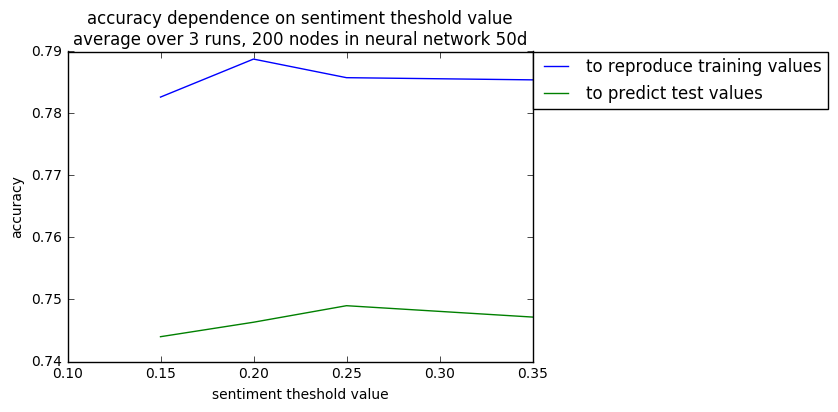

In [19]:
results2=df_results.groupby('Threshold').sum()/runs
plt.plot(results2.index,results2['trainAcc'],label='to reproduce training values')
plt.plot(results2.index,results2['testAcc'],label='to predict test values')
plt.legend(bbox_to_anchor=(1, 1),loc=2,borderaxespad=0.)
plt.title('accuracy dependence on sentiment theshold value\naverage over %s runs, %s nodes in neural network 50d'%(runs,nodes))
plt.xlabel('sentiment theshold value')
plt.ylabel('accuracy')
#plt.savefig('Dependence_Sentiment_nodes%s_50d.png'%(nodes),bbox_inches='tight')
plt.show()

## Next, on number of samples

In [10]:
sentiment=.2;
dimension=50;
training_tweets_per_label=10000;
nodes=200

In [11]:
Training_set=pd.read_csv('Training_set_sentiment_%s_vector_%s_size_%s.csv'%(sentiment, dimension,training_tweets_per_label));
train=Training_set.sample(int(.9*len(Training_set)));
test=Training_set.loc[[index for index in Training_set.index if index not in train.index],:]
vecIndex=train.columns[train.columns.str.contains('vector')]
labelIndex='Sentiment'

In [20]:
subsets=[100,5000,9000,15000] #set based on trainning_tweets_per_label size
df_results=pd.DataFrame(columns=['samples','trainAcc','testAcc'])
nodes=200
x=0
runs=3 #more runs==less noise in average
for y in range(0,runs):
    print('starting run %s'%y)
    for sub in subsets:
        trainsub=train.sample(sub)
        vecIndex=trainsub.columns[trainsub.columns.str.contains('vector')]
        labelIndex='Sentiment'
        clf = MLPClassifier(solver='adam',alpha=1e-1,
                         hidden_layer_sizes=(nodes), random_state=1)
        clf.fit(trainsub.loc[:,vecIndex].values,trainsub.loc[:,labelIndex].values)
        resultsNN=clf.predict(trainsub.loc[:,vecIndex])
        trainAcc=len(resultsNN[trainsub.loc[:,labelIndex].values==resultsNN])/len(resultsNN);
        #print(trainAcc)
        resultsNN_test=clf.predict(test.loc[:,vecIndex])
        testAcc=len(resultsNN_test[test.loc[:,labelIndex].values==resultsNN_test])/len(resultsNN_test);
        #print(testAcc)
        df_results.loc[x,['samples','trainAcc','testAcc']]=[sub,trainAcc,testAcc]
        x=x+1
        #print('completed training with %s samples'%(sub))
    print('completed run %s'%y)

starting run 0


C:\Users\Kyle\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


completed run 0
starting run 1
completed run 1
starting run 2
completed run 2


Here I'm looking for convergence, or expected convergance at the full amount of training data, between the train and test sets.

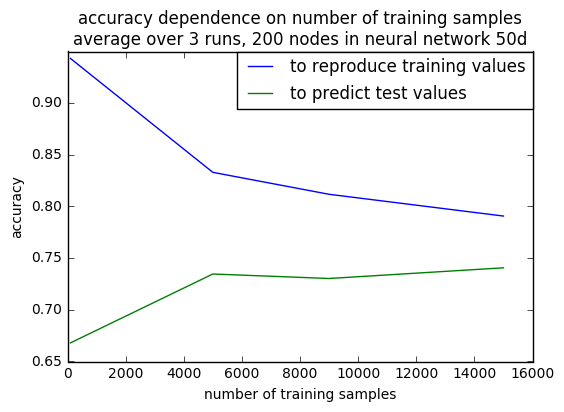

samples
100      0.668000
5000     0.734667
9000     0.730333
15000    0.740667
Name: testAcc, dtype: float64


In [21]:
results2=df_results.groupby('samples').sum()/runs
plt.plot(results2.index,results2['trainAcc'],label='to reproduce training values')
plt.plot(results2.index,results2['testAcc'],label='to predict test values')
plt.legend(bbox_to_anchor=(1, 1),loc=1,borderaxespad=0.)
plt.title('accuracy dependence on number of training samples\naverage over %s runs, %s nodes in neural network 50d'%(runs,nodes))
plt.xlabel('number of training samples')
plt.ylabel('accuracy')
#plt.savefig('Dependence_Samples_nodes%s_50d_long_alpha-5.png'%(nodes),bbox_inches='tight')
plt.show()
print(results2.loc[:,'testAcc'])

# Finally, regularization term, alpha:

In [24]:
sentiment=.2;
dimension=50;
training_tweets_per_label=10000;
nodes=200;
Training_set=pd.read_csv('Training_set_sentiment_%s_vector_%s_size_%s.csv'%(sentiment, dimension,training_tweets_per_label));

In [25]:
regularization=[1e-7,1e-5,1e-4,1e-2,1e-1,5e-1,1e0]
df_results=pd.DataFrame(columns=['reg','trainAcc','testAcc'])
x=0;
runs=3
for y in range(0,runs):
    print('start round %s'%(y))
    for val in regularization:
        sentiment=val;
        try:
            train=Training_set.sample(int(.9*len(Training_set)));
            test=Training_set.loc[[index for index in Training_set.index if index not in train.index],:]
            vecIndex=train.columns[train.columns.str.contains('vector')]
            labelIndex='Sentiment'
            #nodes=150#uncomment if not set above
            clf = MLPClassifier(solver='adam',alpha=val,
                             hidden_layer_sizes=(nodes), random_state=1)
            clf.fit(train.loc[:,vecIndex].values,train.loc[:,labelIndex].values)
            resultsNN=clf.predict(train.loc[:,vecIndex])
            trainAcc=len(resultsNN[train.loc[:,labelIndex].values==resultsNN])/len(resultsNN)
            resultsNN_test=clf.predict(test.loc[:,vecIndex])
            testAcc=len(resultsNN_test[test.loc[:,labelIndex].values==resultsNN_test])/len(resultsNN_test)
            df_results.loc[x,['reg','trainAcc','testAcc']]=[val,trainAcc,testAcc]
            x=x+1
        except:
            print('Fail! Training set has not been made!')
    print('completed round %s'%y)

start round 0
completed round 0
start round 1
completed round 1
start round 2
completed round 2


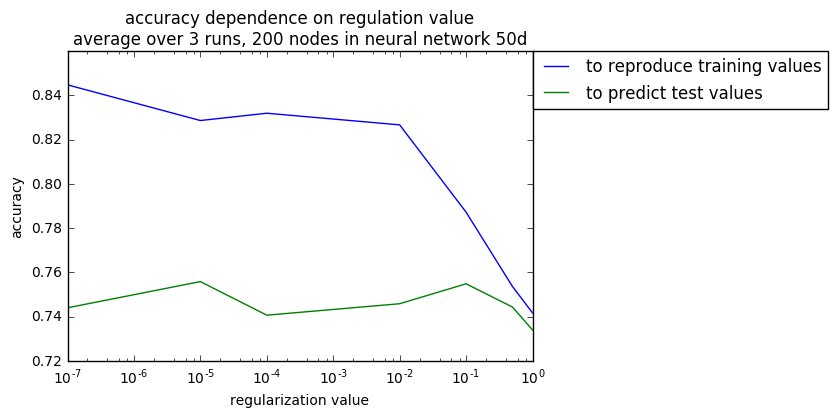

In [26]:
results2=df_results.groupby('reg').sum()/runs
plt.semilogx(results2.index,results2['trainAcc'],label='to reproduce training values')
plt.semilogx(results2.index,results2['testAcc'],label='to predict test values')
plt.legend(bbox_to_anchor=(1, 1),loc=2,borderaxespad=0.)
plt.title('accuracy dependence on regulation value\naverage over %s runs, %s nodes in neural network 50d'%(runs,nodes))
plt.xlabel('regularization value')
plt.ylabel('accuracy')
#plt.savefig('Dependence_regularization_nodes%s_50d.png'%(nodes),bbox_inches='tight')
plt.show()

# With best choice of parameters, create neural network:

In [88]:
sentiment=.2;
dimension=50;
training_tweets_per_label=100000;
nodes=200
reg=1e-1

Training_set=pd.read_csv('Training_set_sentiment_%s_vector_%s_size_%s.csv'%(sentiment, dimension,training_tweets_per_label));
train=Training_set.sample(int(.9*len(Training_set)));
test=Training_set.loc[[index for index in Training_set.index if index not in train.index],:]
vecIndex=train.columns[train.columns.str.contains('vector')]
labelIndex='Sentiment'

clf = MLPClassifier(solver='adam',alpha=reg,
                 hidden_layer_sizes=(nodes), random_state=1)
%time clf.fit(train.loc[:,vecIndex].values,train.loc[:,labelIndex].values)
resultsNN=clf.predict(train.loc[:,vecIndex])
print(len(resultsNN[train.loc[:,labelIndex].values==resultsNN])/len(resultsNN))
resultsNN_test=clf.predict(test.loc[:,vecIndex])
print(len(resultsNN_test[test.loc[:,labelIndex].values==resultsNN_test])/len(resultsNN_test))

Wall time: 42.3 s
0.7622944444444445
0.75575


Some other scores I've seen with different mixes of parameters:

In [ ]:
# sentiment=.2;
# dimension=50;
# training_tweets_per_label=100000;
# nodes=200
# reg=1e-3
# score: 78.6/76.2

# sentiment=.2;
# dimension=50;
# training_tweets_per_label=200000;
# nodes=200
# reg=1e-3
# score: 77.8/76.9

# sentiment=.2;
# dimension=50;
# training_tweets_per_label=200000;
# nodes=200
# reg=1e-2
# score: 77.3/76.5

# sentiment=.2;
# dimension=50;
# training_tweets_per_label=200000;
# nodes=300
# reg=1e-3
# score: 78.4/76.4

# sentiment=.2;
# dimension=50;
# training_tweets_per_label=200000;
# nodes=250
# reg=1e-2
# score: 77.2/76.6

# And pickle the results

Once I have a neural network I'm happy with, I pickle it so that I don't have to retrain it again later. Now I can just unpickle this neural network in another notebook and use it to predict the sentiment of tweets that are not labelled.

In [77]:
with open('NeuralNetwork_hiddenlayer_%s_sentiment_%s_vector_%s_size_%s.pkl'%(nodes,sentiment,dimension,training_tweets_per_label), 'wb') as fid:
    pickle.dump(clf, fid)    

Check that it worked:

In [81]:
sentiment=.2;
dimension=50;
training_tweets_per_label=100000;
nodes=150
reg=1e-1

In [82]:
with open('NeuralNetwork_hiddenlayer_%s_sentiment_%s_vector_%s_size_%s.pkl'%(nodes,sentiment,dimension,training_tweets_per_label), 'rb') as fid:
    clf2 = pickle.load(fid)

In [83]:
resultsNN_test=clf2.predict(test.loc[:,vecIndex])
print(len(resultsNN_test[test.loc[:,labelIndex].values==resultsNN_test])/len(resultsNN_test))

0.7566


One last check. The neural network isn't perfect. It only has a 75-77% accuracy rating. I want to see if that error is evenly distributed between predicting neg tweets and positive tweets, or if it's predominantly for one or the other.

If it's equally distributed, the error rate can by and large be ignored when averaging over many tweets. If it's not, I'll need to worry about the error rate. on later analysis.

In [84]:
#try verify error isn't in only one sentiment type
print(clf2.predict(test.loc[test.loc[:,'Sentiment']==0,vecIndex]).mean())
print(1-clf2.predict(test.loc[test.loc[:,'Sentiment']==1,vecIndex]).mean())

0.25829075243
0.228565725122
